<h1>
<div class = "alert alert-info">
<dt>Sentiment Analysis and recommendation on Amazon's Electronics Dataset</dt>
</div>
</h1>

## purpose
1. 
2. 

<font size="+1.5">
<div class="alert alert-block alert-warning">
<dt>Data Import</dt>
</div>
</font>

In [1]:
# return all results in the cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import gzip
import json
import pprint

import contractions
import re

import string
punctuations = string.punctuation
# removed '!' and '?'
revised_punct = '"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'

# loading the nlp model
import spacy
# "parser", "ner"
nlp = spacy.load("en_core_web_sm", disable=["textcat", 
                                            "textcat_multilabel", 
                                            "entity_linker", "custom"
                                           ])

from spacy.tokenizer import Tokenizer

# Creating a Spacy Parser -- Eng
from spacy.lang.en import English
parser = English()

# getting stopwords from spacy 
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

from spacymoji import Emoji
emoji = Emoji(nlp)
nlp.add_pipe('emoji', first=True)


In [3]:
# save the json file path
file_name = "Electronics.json"

In [4]:
# read the json file line by line
class json_generator_pipe:
        
    # initialize all parameters
    '''
    file_name is where we save the file path as above
    print_lines is a parameter to determine how many data can be shown if the data and the class works well
    save_lines is a parameter to decide how many data you generate from the json file
    '''
    def __init__(self, file_name, print_lines=1, save_lines= 9999):
        self.file_name = file_name
        self.print_lines = print_lines
        self.save_lines = save_lines
        
    # get the file object
    def read_json_file(self):
        file_object = open(self.file_name, 'r')
        return file_object

    # get the generator to load data
    def get_generator(self):
        file_object = self.read_json_file()
        while True:
            line = file_object.readline()
            if len(line) == 0:
                break
            data = json.loads(line)
            yield data
    
    # print the data to see if the class works well
    def print_data(self):
        data_generator = self.get_generator()
        num_lines = 0
        for tmp in data_generator:
            if num_lines == self.print_lines:
                break
            num_lines += 1
            pprint.pprint(tmp)
            print()
    
    # save the data for the following manipulation
    def save_data(self):
        data_generator = self.get_generator()
        data = []
        num_lines = 0
        for temp in data_generator:
            num_lines += 1
            data.append(temp)
            if num_lines == self.save_lines:
                break
        return data

# implement the class, print_data function, and raw_data for next step
load_class = json_generator_pipe(file_name=file_name)
print_data = load_class.print_data()
raw_data = load_class.save_data()

{'asin': '0060009810',
 'overall': 5.0,
 'reviewText': 'This was the first time I read Garcia-Aguilera.  I came upon '
               'the name of this book on Live with Regis and Kelly. This book '
               'was exactly what I was looking for ... it hit the spot.  I '
               'really enjoyed this book because it was well written. Once I '
               'started this book it kept me coming back for more. It had '
               'culture, family, friendship and romance. I was looking for a '
               'little more romance when I picked this book but in the end it '
               'turned out to be just right.  I love the main chartachter '
               "Margarita (aka Daisy). I've never been to Miami but the way "
               "Daisy told the story I certainly felt I'd been there.\n"
               "Also after going through all of Daisy's perils ... I closed "
               'the book with a feeling I had grown emotionally as well.',
 'reviewTime': '07 17, 2002',


In [5]:
# transform the json object to dataframe
df = pd.json_normalize(raw_data)
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style.Format:,vote,image,style.Color:
0,5.0,True,"07 17, 2002",A1N070NS9CJQ2I,0060009810,Teri Adams,This was the first time I read Garcia-Aguilera...,Hit The Spot!,1026864000,Hardcover,NaN,NaN,NaN
1,5.0,False,"07 6, 2002",A3P0KRKOBQK1KN,0060009810,Willa C.,"As with all of Ms. Garcia-Aguilera's books, I ...",one hot summer is HOT HOT HOT!,1025913600,Hardcover,NaN,NaN,NaN
2,5.0,False,"07 3, 2002",A192HO2ICJ75VU,0060009810,Kit,I've not read any of Ms Aguilera's works befor...,One Hot Summer,1025654400,Hardcover,2,NaN,NaN
3,4.0,False,"06 30, 2002",A2T278FKFL3BLT,0060009810,Andres,This romance novel is right up there with the ...,I love this book!,1025395200,Hardcover,3,NaN,NaN
4,5.0,False,"06 28, 2002",A2ZUXVTW8RXBXW,0060009810,John,Carolina Garcia Aguilera has done it again. S...,One Hot Book,1025222400,Hardcover,NaN,NaN,NaN


In [6]:
# show the num counts
# when data count is too many, it may not be shown. show_counts is the parameter to show the data count no matter how many
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         9999 non-null   float64
 1   verified        9999 non-null   bool   
 2   reviewTime      9999 non-null   object 
 3   reviewerID      9999 non-null   object 
 4   asin            9999 non-null   object 
 5   reviewerName    9999 non-null   object 
 6   reviewText      9998 non-null   object 
 7   summary         9997 non-null   object 
 8   unixReviewTime  9999 non-null   int64  
 9   style.Format:   4502 non-null   object 
 10  vote            1842 non-null   object 
 11  image           33 non-null     object 
 12  style.Color:    382 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 947.3+ KB


### Data Wrangling

In [7]:
# only get the text reviewtest and rating columns as a new dataframe 'review_df'
review_df = df[['reviewText', 'overall']]
review_df = review_df.rename(columns={'overall': 'Rating'})

# set index as column number into dataframe
review_df['ID'] = review_df.index
review_df = review_df[['ID', 'reviewText', 'Rating']]
review_df.head()

,ID,reviewText,Rating
0,0,This was the first time I read Garcia-Aguilera...,5.0
1,1,"As with all of Ms. Garcia-Aguilera's books, I ...",5.0
2,2,I've not read any of Ms Aguilera's works befor...,5.0
3,3,This romance novel is right up there with the ...,4.0
4,4,Carolina Garcia Aguilera has done it again. S...,5.0


In [8]:
review_df['Rating'] = np.where(review_df['Rating'] > 3, 1, 0)

In [10]:
# check if any Null value
review_df.isnull().sum()

ID            0
reviewText    1
Rating        0
dtype: int64

In [11]:
# drop the Null value if it's not many
review_df = review_df.dropna()

# check if the Null value is deleted
review_df.isnull().sum()
review_df.count()

# need to reindex 
review_df.reset_index(drop=True, inplace=True)

ID            0
reviewText    0
Rating        0
dtype: int64

ID            9998
reviewText    9998
Rating        9998
dtype: int64

In [12]:
# reviewtext is a emoji, need to deal with later
df.iloc[12770:12771, :7]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText


In [13]:
# URL Counts
pattern =  r'(?:http://)?\w+\.\S*[^.\s]'
tweet = ('PyBites My Reading List | 12 Rules for Life - #books '
             'that expand the mind! '
             'www.google.com/telephone/wire....  '
             'http://pbreadinglist.herokuapp.com/books/'
             'TvEqDAAAQBAJ#.XVOriU5z2tA.twitter '
             "http://-www.pip.org "
             "google.com "
             "twitter.com "
             "facebook.com"
             ' #psychology #philosophy')

re.findall(pattern, tweet)

# 'Yes' represents the comment includes URL, 'No' means it doesn't have
review_df['reviewText'] = review_df['reviewText'].apply(lambda string : re.sub(pattern, "", string))

['www.google.com/telephone/wire',
 'http://pbreadinglist.herokuapp.com/books/TvEqDAAAQBAJ#.XVOriU5z2tA.twitter',
 'www.pip.org',
 'google.com',
 'twitter.com',
 'facebook.com']

C:\Users\jerry\AppData\Local\Temp/ipykernel_26136/3297700355.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['reviewText'] = review_df['reviewText'].apply(lambda string : re.sub(pattern, "", string))


In [14]:
# Accented Chars Counts
import unicodedata
def remove_acc_data(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

# 'Yes' represents the comment has Accented Chars, 'No' means it doesn't have
review_df['reviewText'] = review_df['reviewText'].apply(lambda string : remove_acc_data(string))


C:\Users\jerry\AppData\Local\Temp/ipykernel_26136/3816312430.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['reviewText'] = review_df['reviewText'].apply(lambda string : remove_acc_data(string))


In [15]:
# remove multiple spaces in the comments
review_df['reviewText'] = review_df['reviewText'].apply(lambda string : " ".join(string.split()))

C:\Users\jerry\AppData\Local\Temp/ipykernel_26136/382662102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['reviewText'] = review_df['reviewText'].apply(lambda string : " ".join(string.split()))


In [16]:
# expand the short forms, expecailly "'ve" to have that can not achieve in the sapcy
review_df['reviewText'] = review_df['reviewText'].apply(lambda string : contractions.fix(string))

C:\Users\jerry\AppData\Local\Temp/ipykernel_26136/3179821623.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['reviewText'] = review_df['reviewText'].apply(lambda string : contractions.fix(string))


In [18]:
%%time
review_df['revised'] = review_df['reviewText'].apply(lambda string: nlp(string))

Wall time: 1min 56s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
tags = ['JJR', 'JJS', 'RBR', 'RBS']
def get_tags(text):
    res = []
    for token in text:
        if token.tag_ in tags:
            res.append(token.lower_)
        else:
            res.append(token.lemma_.lower())
    return res
        
# lemma = lambda text: " ".join([token.lower_ for token in text
#                                if token.lemma_ in tags 
#                                else token.lemma_.lower()])


In [20]:
review_df['revised1'] = review_df['revised'].apply(lambda doc: get_tags(doc))

C:\Users\jerry\AppData\Local\Temp/ipykernel_26136/2004571699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['revised1'] = review_df['revised'].apply(lambda doc: get_tags(doc))


In [21]:
def punctuations_remover(text):
    res = []
    '''remove the punctuations of each comment'''
#         punct_string_list = []
    for token in text:
        if token not in revised_punct:
            res.append(token)
    return res

In [22]:
review_df['revised2'] = review_df['revised1'].apply(lambda doc: punctuations_remover(doc))

C:\Users\jerry\AppData\Local\Temp/ipykernel_26136/2464897587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['revised2'] = review_df['revised1'].apply(lambda doc: punctuations_remover(doc))


In [23]:
def stopwords_remover(text):
    stpw_string = []
        
    for token in text:
        if token not in stopwords:
            stpw_string.append(token)
    return stpw_string

In [24]:
review_df['revised3'] = review_df['revised2'].apply(lambda doc: stopwords_remover(doc))

C:\Users\jerry\AppData\Local\Temp/ipykernel_26136/788871023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['revised3'] = review_df['revised2'].apply(lambda doc: stopwords_remover(doc))


In [25]:
# phrase modeling using noun chunk and named entity

In [26]:
def named_entity(text):
    res = []
    for ent in text.ents:
        res.append(ent.text.lower())
    return res

In [27]:
review_df['revised4'] = review_df['revised'].apply(lambda doc: named_entity(doc))

C:\Users\jerry\AppData\Local\Temp/ipykernel_26136/3235125434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['revised4'] = review_df['revised'].apply(lambda doc: named_entity(doc))


In [28]:
def name_chunk(text):
    res = []
    for chunk in text.noun_chunks:
        res.append(chunk.text.lower())
    return res

In [29]:
review_df['revised5'] = review_df['revised'].apply(lambda doc: name_chunk(doc))

C:\Users\jerry\AppData\Local\Temp/ipykernel_26136/562258066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['revised5'] = review_df['revised'].apply(lambda doc: name_chunk(doc))


In [30]:
def name_chunk_add(review_df):
    try:
        
        comparison_candidate = review_df['revised3']
        need_to_compare = review_df['revised4'] + review_df['revised5']
        res = comparison_candidate

        for index, noun_list in enumerate(need_to_compare):
            for token in noun_list:
                if token not in set(comparison_candidate[index]):
                    res[index].append(token)
        return res
    
    except KeyError:
        return res

In [31]:
review_df['revised6'] = name_chunk_add(review_df)

C:\Users\jerry\AppData\Local\Temp/ipykernel_26136/1625210226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['revised6'] = name_chunk_add(review_df)


In [32]:
tokenized = review_df['revised6']

In [33]:
# tokenized = review_df['revised3']

In [34]:
# TF-IDF

In [35]:
from gensim.corpora.dictionary import Dictionary

vocabulary = Dictionary(tokenized)
vocabulary.filter_extremes(no_below=20, no_above=0.2)
vocabulary.compactify()

vocabulary_keys = list(vocabulary.token2id)[0:10]

for key in vocabulary_keys:
    print(f"ID: {vocabulary.token2id[key]}, Token: {key}")

ID: 0, Token: ...
ID: 1, Token: all
ID: 2, Token: certainly
ID: 3, Token: close
ID: 4, Token: come
ID: 5, Token: culture
ID: 6, Token: end
ID: 7, Token: enjoy
ID: 8, Token: exactly
ID: 9, Token: exactly what


In [36]:
bow = [vocabulary.doc2bow(doc) for doc in tokenized]

for idx, freq in bow[0]:
    print(f"Word: {vocabulary.get(idx)}, Frequency: {freq}")

Word: ..., Frequency: 2
Word: all, Frequency: 1
Word: certainly, Frequency: 1
Word: close, Frequency: 1
Word: come, Frequency: 2
Word: culture, Frequency: 1
Word: end, Frequency: 1
Word: enjoy, Frequency: 1
Word: exactly, Frequency: 1
Word: exactly what, Frequency: 1
Word: family, Frequency: 1
Word: feel, Frequency: 1
Word: feeling, Frequency: 1
Word: first, Frequency: 1
Word: friendship, Frequency: 1
Word: grow, Frequency: 1
Word: hit, Frequency: 1
Word: little, Frequency: 1
Word: live, Frequency: 1
Word: look, Frequency: 2
Word: main, Frequency: 1
Word: me, Frequency: 1
Word: pick, Frequency: 1
Word: right, Frequency: 1
Word: romance, Frequency: 2
Word: spot, Frequency: 1
Word: start, Frequency: 1
Word: story, Frequency: 1
Word: tell, Frequency: 1
Word: the book, Frequency: 1
Word: the end, Frequency: 1
Word: the first time, Frequency: 1
Word: the story, Frequency: 1
Word: this book, Frequency: 1
Word: time, Frequency: 1
Word: turn, Frequency: 1
Word: way, Frequency: 1
Word: write, F

In [37]:
# 越大越重要
from gensim.models.tfidfmodel import TfidfModel

tfidf = TfidfModel(bow, id2word=vocabulary)


for idx, weight in tfidf[bow[0]]:
    print(f"Word: {vocabulary.get(idx)}, Weight: {weight:.3f}")

Word: ..., Weight: 0.264
Word: all, Weight: 0.112
Word: certainly, Weight: 0.193
Word: close, Weight: 0.178
Word: come, Weight: 0.201
Word: culture, Weight: 0.226
Word: end, Weight: 0.115
Word: enjoy, Weight: 0.097
Word: exactly, Weight: 0.153
Word: exactly what, Weight: 0.183
Word: family, Weight: 0.133
Word: feel, Weight: 0.116
Word: feeling, Weight: 0.194
Word: first, Weight: 0.102
Word: friendship, Weight: 0.255
Word: grow, Weight: 0.185
Word: hit, Weight: 0.198
Word: little, Weight: 0.110
Word: live, Weight: 0.155
Word: look, Weight: 0.187
Word: main, Weight: 0.148
Word: me, Weight: 0.076
Word: pick, Weight: 0.169
Word: right, Weight: 0.123
Word: romance, Weight: 0.310
Word: spot, Weight: 0.202
Word: start, Weight: 0.119
Word: story, Weight: 0.078
Word: tell, Weight: 0.132
Word: the book, Weight: 0.103
Word: the end, Weight: 0.148
Word: the first time, Weight: 0.216
Word: the story, Weight: 0.118
Word: this book, Weight: 0.083
Word: time, Weight: 0.082
Word: turn, Weight: 0.114
Wo

In [38]:
docs_tfidf = tfidf[bow]
from gensim.matutils import sparse2full

In [39]:
%%time
docs_vecs = np.vstack([sparse2full(c, len(vocabulary)) for c in docs_tfidf])

Wall time: 1.23 s


In [40]:
docs_vecs.shape

(9998, 2313)

In [41]:
tfidf_emb_vecs = np.vstack([nlp(vocabulary[i]).vector for i in range(len(vocabulary))])

In [42]:
docs_emb = np.dot(docs_vecs, tfidf_emb_vecs)

In [43]:
model_df = pd.DataFrame(docs_emb)
model_df["label"] = review_df["Rating"]

display(model_df.head())

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,label
0,-3.350556,-1.389183,0.956055,3.264151,0.884456,-0.085451,1.032495,2.594609,-0.726739,0.059141,...,1.105538,-2.947981,2.650774,-3.581011,-0.587705,-3.489867,0.953779,5.482666,0.809226,1
1,-1.211052,-0.267716,1.012455,1.841263,-0.802114,0.082516,-0.808789,0.800068,-0.397970,0.123186,...,-0.212506,-1.817270,-0.049529,0.231804,-0.446672,-0.439933,0.002256,3.377240,0.197218,1
2,-1.289004,-0.786475,1.026412,2.601986,-0.610665,-0.159659,-0.719362,1.469169,-0.339422,-0.369994,...,0.084332,-1.322593,1.429223,-1.780594,-1.267735,-1.706541,0.892440,2.473776,0.484116,1
3,-2.882333,-1.190479,0.819220,2.058869,-0.749763,0.229447,-1.539450,1.785059,-0.523463,-0.241924,...,-0.108942,-2.390482,0.966820,-0.930216,-1.280900,-2.330873,1.412799,5.059027,0.655674,1
4,-1.348990,-0.852109,0.263962,2.079113,-0.046367,-0.261220,-1.348241,1.102972,-0.634390,-0.490819,...,-0.658933,-0.786192,1.327013,-1.213115,-1.508843,-0.523598,0.159971,2.526519,0.123264,1


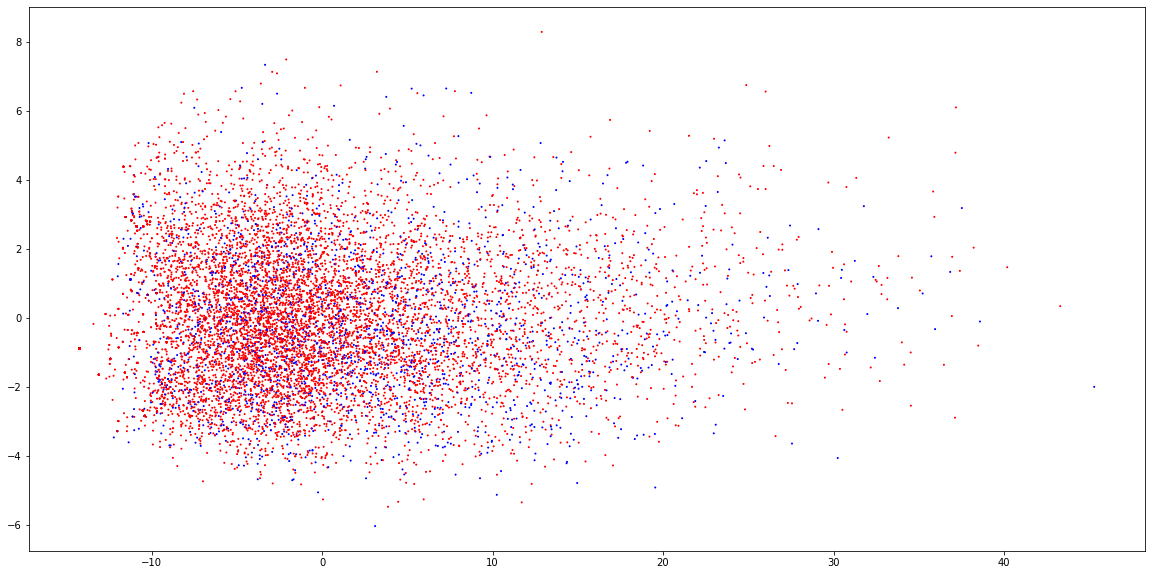

In [50]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#sampling the model_df population
pca_df = model_df.reset_index()
pca_df = model_df.dropna(axis=0).iloc[:,1:]
# pca_df = pca_df.iloc[::50]

#setting up PCA
pca = PCA(n_components=2, random_state=42)
pca = pca.fit_transform(pca_df.iloc[:, :-1])
labels = pca_df["label"]

#setting up plot components
x_axis = pca[:,0]
y_axis = pca[:,1]
color_map = pca_df["label"].map({0:"blue", \
                                 1:"red" })
#                                  3:"yellow", \
#                                  4:"green", \
#                                  5:"orange"})

#plotting PCA
f, axes = plt.subplots(figsize=(20,10))
plt.scatter(x_axis, y_axis, color=color_map, s=1)
plt.show()

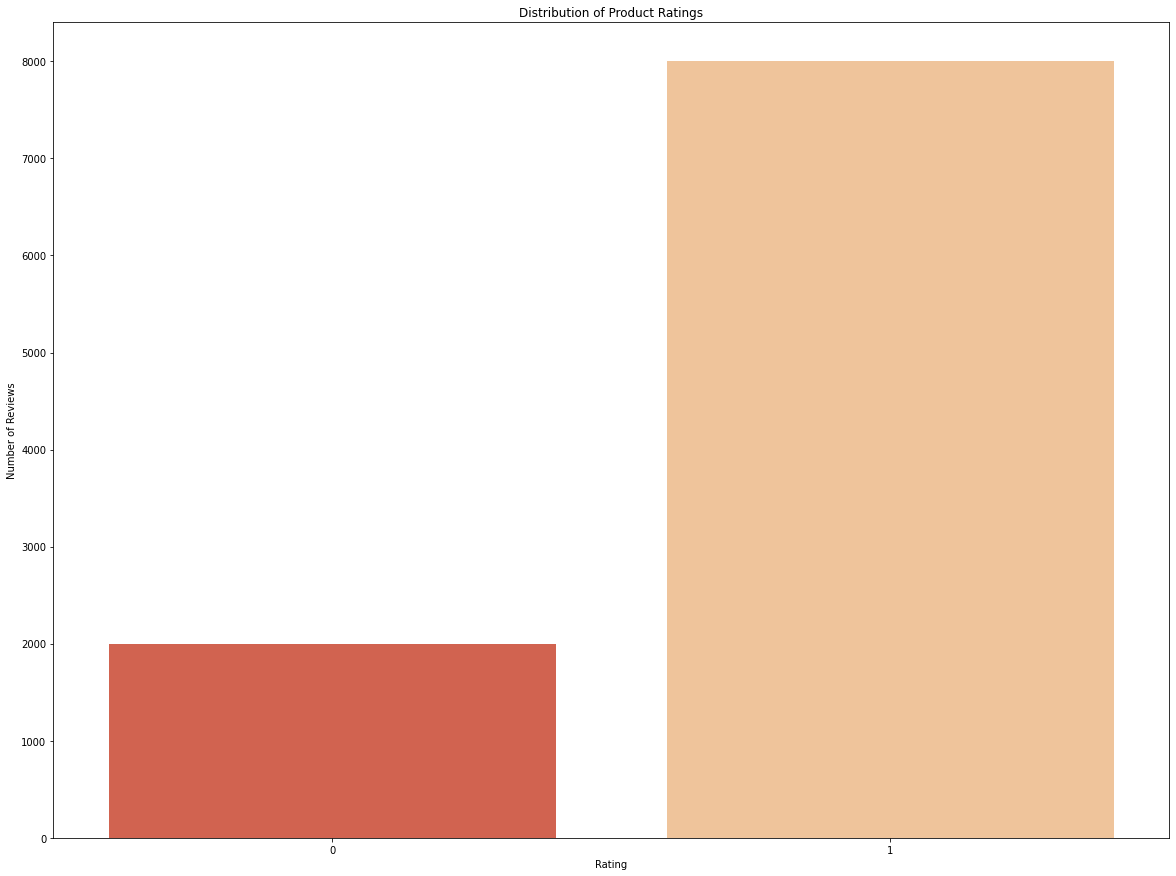

In [51]:
import seaborn as sns

f, axes = plt.subplots(figsize=(20,15))
ax = sns.countplot(x=review_df["Rating"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show();

In [52]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [79]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

In [80]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, \
                                criterion="entropy", random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
SMOTE = SMOTE(random_state=0, sampling_strategy='not majority')

In [81]:
X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

In [82]:
from sklearn.model_selection import train_test_split

for train, test, in kf.split(X, y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

In [83]:
X_train_oversampled, y_train_oversampled = SMOTE.fit_resample(X_train, y_train)

In [84]:
# random forest

forest.fit(X_train_oversampled, y_train_oversampled )

RandomForestClassifier(criterion='entropy', n_estimators=25, random_state=42)

In [85]:
from sklearn import metrics
y_pred = forest.predict(X_train_oversampled)

accuracy = metrics.accuracy_score(y_train_oversampled, y_pred)
f1_score = metrics.f1_score(y_train_oversampled, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 98.850%
Training Set F1 Score: 0.988


In [92]:
# get the classification report
from sklearn.metrics import classification_report

predictions = forest.predict(X_test)
print(classification_report(y_test, predictions))
# Accuracy of the train and test dataset
print('Accuracy of the train dataset: {:.4f}'.format(forest.score(X_train_oversampled, y_train_oversampled)))
print('Accuracy of the test dataset: {:.4f}'.format(forest.score(X_test, y_test)))

              precision    recall  f1-score   support

           0       0.36      0.32      0.34       213
           1       0.82      0.85      0.83       786

    accuracy                           0.73       999
   macro avg       0.59      0.58      0.59       999
weighted avg       0.72      0.73      0.73       999

Accuracy of the train dataset: 0.9885
Accuracy of the test dataset: 0.7347


In [93]:
# XGBoost

In [ ]:
# testing the original data

In [111]:
from sklearn.model_selection import train_test_split

X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [112]:
y_pred_org = forest.predict(X_train_org)

accuracy_org = metrics.accuracy_score(y_train_org, y_pred_org)
f1_score_org = metrics.f1_score(y_train_org, y_pred_org, average="micro")

print(f"Training Set Accuracy: {accuracy_org*100:.3f}%")
print(f"Training Set F1 Score: {f1_score_org:.3f}")

Training Set Accuracy: 96.842%
Training Set F1 Score: 0.968


In [113]:
predictions_org = forest.predict(X_test_org)
print(classification_report(y_test_org, predictions_org))
# Accuracy of the train and test dataset
print('Accuracy of the train dataset: {:.4f}'.format(forest.score(X_train_org, y_train_org)))
print('Accuracy of the test dataset: {:.4f}'.format(forest.score(X_test_org, y_test_org)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       599
           1       0.97      0.98      0.98      2401

    accuracy                           0.96      3000
   macro avg       0.95      0.93      0.94      3000
weighted avg       0.96      0.96      0.96      3000

Accuracy of the train dataset: 0.9684
Accuracy of the test dataset: 0.9627


In [88]:
# testing the org data with rf fitting org

In [116]:
forest_org = RandomForestClassifier(n_estimators=25, \
                                criterion="entropy", random_state=42)

In [117]:
forest_org.fit(X_train_org, y_train_org)

RandomForestClassifier(criterion='entropy', n_estimators=25, random_state=42)

In [118]:
y_pred_rf_org = forest_org.predict(X_train_org)

accuracy_rf_org = metrics.accuracy_score(y_train_org, y_pred_rf_org)
f1_score_rf_org = metrics.f1_score(y_train_org, y_pred_rf_org, average="micro")

print(f"Training Set Accuracy: {accuracy_rf_org*100:.3f}%")
print(f"Training Set F1 Score: {accuracy_rf_org:.3f}")

Training Set Accuracy: 99.100%
Training Set F1 Score: 0.991


In [119]:
predictions_rf_org = forest_org.predict(X_test_org)
print(classification_report(y_test_org, predictions_rf_org))
# Accuracy of the train and test dataset
print('Accuracy of the train dataset: {:.4f}'.format(forest_org.score(X_train_org, y_train_org)))
print('Accuracy of the test dataset: {:.4f}'.format(forest_org.score(X_test_org, y_test_org)))

              precision    recall  f1-score   support

           0       0.53      0.07      0.12       599
           1       0.81      0.99      0.89      2401

    accuracy                           0.80      3000
   macro avg       0.67      0.53      0.50      3000
weighted avg       0.75      0.80      0.73      3000

Accuracy of the train dataset: 0.9910
Accuracy of the test dataset: 0.8017
